In [33]:
# Developing Multiagent 
# Simple agent can helucinate
# Avoide wronge call of tools

#Multiagent
#there are two type of multiagent
# 1. Network type agent
# 2. Supervious base agent

In [ ]:
# Develop multiagentsystem
from dotenv import load_dotenv
# we can customize the state as per requirement
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage,HumanMessage
from typing import Annotated,Sequence,TypedDict
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import create_react_agent
from langchain.tools import BaseTool
from typing import Dict
from langchain_groq import ChatGroq
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
load_dotenv()

True

In [ ]:
# we are going to use decoder model

llm = ChatGroq(model = "openai/gpt-oss-20b")

In [131]:
llm.invoke("Hello how are you?")

AIMessage(content="Hello! I'm just a bunch of code, but I'm running smoothly—thanks for asking. How can I help you today?", additional_kwargs={'reasoning_content': 'We need to respond politely. No policy issues.'}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 76, 'total_tokens': 121, 'completion_time': 0.045628811, 'prompt_time': 0.027373006, 'queue_time': 0.136463463, 'total_time': 0.073001817, 'completion_tokens_details': {'reasoning_tokens': 11}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3139a6ae-46b8-43d1-9588-e671d5ab321b-0', usage_metadata={'input_tokens': 76, 'output_tokens': 45, 'total_tokens': 121})

In [133]:
class Agent_tools():

    def __init__(self,state):
        self.state = state

    def add_number(self):
        result = self.state["num1"] + self.state["num2"]
        print(f"Addition is{result}")
        return Command(goto = "multiply",update = {"sum":result})
    

In [134]:
state = {"num1":10,"num2":20}
tools = Agent_tools(state)
tools.add_number()


Addition is30


Command(update={'sum': 30}, goto='multiply')

In [135]:


class AgenticState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]
    num1:int
    num2:int


In [136]:
from typing_extensions import Literal 
from typing import Optional

In [ ]:

class MultiplicationTool(BaseTool):
      name: str = "Multiplication"
      description: str = "Multiply two numbers from the given state dictionary"

      # Declare state as an optional field (Pydantic-compatible)
      state: Optional[Dict] = None
      def __init__(self, state):
            super().__init__()
            self.state = state

      def _run(self,**kwargs) -> Command[Literal["AdditionTool","__end__"]]:
            num1 = self.state.get("num1", 0)
            num2 = self.state.get("num2", 0)
            result = num1 * num2
            self.state["result"] = result
            return f"The multiplication of {num1} and {num2} is {result}"


      async def _arun(self, **kwargs) -> Command[Literal["AdditionTool","__end__"]]:
            self._run(**kwargs)

In [138]:
class AdditionTool(BaseTool):
    
    name: str = "Addition"
    description: str = "Addition two numbers from the given state dictionary"

    # Declare state as an optional field (Pydantic-compatible)
    state: Optional[Dict] = None
    
    def __init__(self, state):
        super().__init__()
        self.state = state

    def _run(self, **kwargs) -> Command[Literal["MultiplicationTool","__end__"]]:
        num1 = self.state.get("num1", 0)
        num2 = self.state.get("num2", 0)
        result = num1 + num2
        self.state["result"] = result
        return f"The Adition of {num1} and {num2} is {result}"
       

    async def _arun(self, **kwargs) -> Command[Literal["MultiplicationTool","__end__"]]:
        self._run(**kwargs)


In [139]:
# Initialize tools with shared state
# Shared state
state = {"num1": 5, "num2": 3}
mult_tool = MultiplicationTool(state =state)
add_tool = AdditionTool(state =state)
llm_with_tools = llm.bind_tools([mult_tool,add_tool])

In [140]:
mult_tool.invoke(state)

'The multiplication of 5 and 3 is 15'

In [141]:
add_tool.invoke(state)

'The Adition of 5 and 3 is 8'

In [142]:
response = llm_with_tools.invoke("multiply 2 by 3")

In [143]:
response.tool_calls

[{'name': 'Multiplication',
  'args': {'kwargs': {'a': 2, 'b': 3}},
  'id': 'fc_7db0133c-553c-4200-aa5d-fd8489c179e9',
  'type': 'tool_call'}]

# Multiagent in real world problem using Network Multiagent

In [144]:
from langchain_community.tools import DuckDuckGoSearchRun

In [145]:
search_tool = DuckDuckGoSearchRun()

In [146]:
search_tool.invoke("who is a current pm of india?")

"India follows a parliamentary system in which the prime minister is the presiding head of the government and chief of the executive of the government. In such systems, the head of state, or, the head of state's official representative (i.e., the monarch, president, or governor-general) usually holds a purely ceremonial position and acts, on most matters, only on the advice of the prime ... List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office on 10 June 2024. The Prime Minister, Shri Narendra Modi today shared an article written by Union Minister, Shri Amit Shah on Bharat's national song, composed by Bankim Chandra Chattopadhyay, the eternal song of India's freedom. List of Prime Minister of India : 1947 to 2025 Narendra Modi is the current Prime Minister of India in 2025, serving the nation for the past 11 years since first taking office in 2014. The list of Indian Prime Ministers begins with Jawaharlal Nehru,

In [147]:
from langchain_experimental.utilities import PythonREPL

In [148]:
# It is used to run python code that is given in string
repl = PythonREPL()

In [ ]:
code = ""

'10\n'

In [150]:
from langchain.tools import BaseTool
from typing import Annotated

class PythonReplTool(BaseTool):
    name: str = "python_repl_tool"
    description: str = (
        "Use this to execute python code. Use print(...) to see output."
    )

    def _run(
        self,
        code: Annotated[str, "The python code to execute to generate your chart."]
    ) -> str:
        try:
            result = repl.run(code)
        except BaseException as e:
            return f"Failed to execute. Error: {repr(e)}"
        return f"Successfully executed:\n'''python\n{code}\n'''\nStdout: {result}"


In [151]:
python_tool = PythonReplTool()

In [152]:
print(python_tool.invoke(code))

Successfully executed:
'''python
x = 5
y = x*2
print(y)
'''
Stdout: 10



In [153]:
def make_system_prompt(instruction:str)->str:
    return ("You are a helpful AI assistant, collaborating with" 
    "other assistants.Use provided tools to progress towards the answering the question"
    "If you are unable to fully answer, that 's ok ,another with different tools will help"
    "where you left off. Execute what you can to make progress."
    "If you or any of the other assistant have the final answer or deliverable,"
    "Prefix your response with FINAL ANSWER so the team knows to stop"
    f"\n{instruction}")

def get_next_node(last_message:BaseMessage,goto:str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto
    

In [ ]:
# Agent1- research 

def research_node(state:MessagesState)->Command[Literal["chart_generator","__end__"]]:

    research_agent = create_react_agent(llm,
                                        tools = [search_tool],
                                        prompt = make_system_prompt("you can only do research. you are working with " \
                                        "a chart generator colleague"
                                        ),)
    result = research_agent.invoke(state)

    
    goto = "chart_generator"
    goto = get_next_node( result["messages"][-1],goto)

    result["messages"][-1] = HumanMessage(content = result["messages"][-1].content,name ="chart_generator")
    

    return Command(update={"messages":result["messages"]},goto = goto)
    
       

In [156]:
def chart_node(state:MessagesState)->Command[Literal["researcher","__end__"]]:

    chart_agent = create_react_agent(llm,
                                     tools = [PythonReplTool()],
                                     prompt = make_system_prompt("you can only generate charts." \
                                     "You can work with a researcher colleague."))
    result = chart_agent.invoke(state)
 
    goto = "researcher"
    goto = get_next_node( result["messages"][-1],goto)
    
    result["messages"][-1] = HumanMessage(content = result["messages"][-1].content,name ="researcher")

    return Command(update={"messages":result["messages"]},goto = goto)
    

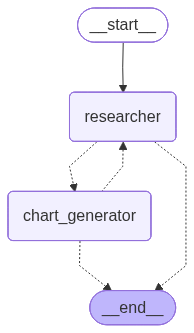

In [ ]:
workflow =StateGraph(MessagesState)
workflow.add_node("researcher",research_node)
workflow.add_node("chart_generator",chart_node)
workflow.add_edge(START,"researcher")
app = workflow.compile()
app

In [ ]:
app.invoke({"messages":[("user","get the UK's GDP over the past 3 years, then generate a line chart of it.Once you make the chart, finish.")]})

{'messages': [HumanMessage(content='get uk gdp over past 2 years,then make line chart of it.once you make the chart,finish ', additional_kwargs={}, response_metadata={}, id='455a0eb7-915d-4285-b8ce-4dcd00cec580'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to get UK GDP over past 2 years. Likely we need data for 2022 and 2023. We need to browse search for UK GDP 2022, 2023. Then generate line chart. We have no chart generator tool; but we can produce chart in text or use ASCII? The instruction: "you are working with a chart generator colleague". So we need to provide data and then ask colleague to generate chart? The instructions: "you are a helpful AI assistant, collaborating with other assistants. Use provided tools to progress towards answering the question. If you are unable to fully answer, that\'s ok, another with different tools will help where you left off. Execute what you can to make progress. If you or any of the other assistant have the final a